Using device: cuda
Loaded pre-trained model.


C:\Users\23169\AppData\Local\Temp\ipykernel_135104\2062059453.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Epoch [1000/200000] Train Loss: 0.00000008
Epoch [2000/200000] Train Loss: 0.00000008
Epoch [3000/200000] Train Loss: 0.00000008
Epoch [4000/200000] Train Loss: 0.00000008
Epoch [5000/200000] Train Loss: 0.00000008
Epoch [6000/200000] Train Loss: 0.00000008
Epoch [7000/200000] Train Loss: 0.00000008
Epoch [8000/200000] Train Loss: 0.00000008
Epoch [9000/200000] Train Loss: 0.00000008
Epoch [10000/200000] Train Loss: 0.00000008
Epoch [11000/200000] Train Loss: 0.00000008
Epoch [12000/200000] Train Loss: 0.00000008
Epoch [13000/200000] Train Loss: 0.00000008
Epoch [14000/200000] Train Loss: 0.00000008
Epoch [15000/200000] Train Loss: 0.00000008
Epoch [16000/200000] Train Loss: 0.00000008
Epoch [17000/200000] Train Loss: 0.00000008
Epoch [18000/200000] Train Loss: 0.00000008
Epoch [19000/200000] Train Loss: 0.00000008
Epoch [20000/200000] Train Loss: 0.00000008
Epoch [21000/200000] Train Loss: 0.00000008
Epoch [22000/200000] Train Loss: 0.00000008
Epoch [23000/200000] Train Loss: 0.000000

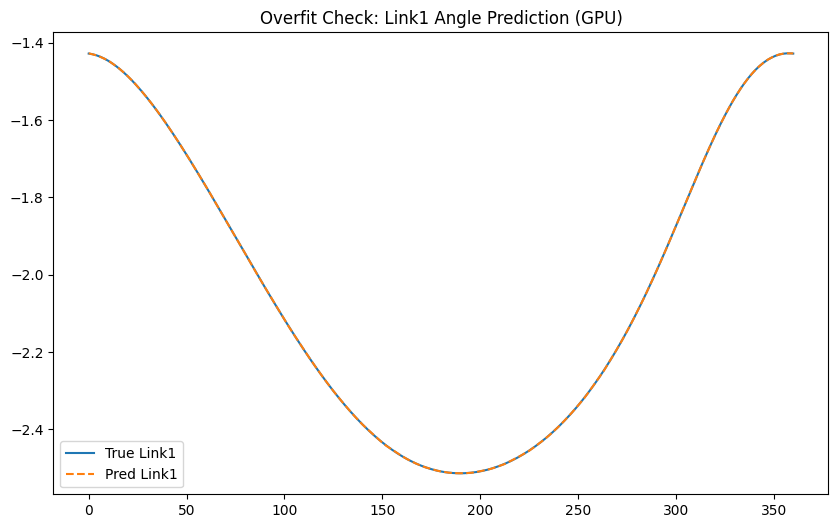

Model saved successfully.


In [ ]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 检查设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_file = 'input.csv'
output_file = 'output.csv'

def load_data(input_file, output_file):
    # 1. 读取数据
    x = pd.read_csv(input_file, header=None).values.astype(np.float32)
    y = pd.read_csv(output_file, header=None).values.astype(np.float32)

    # 数据归一化
    x_min = x.min(axis=0)
    x_max = x.max(axis=0)
    y_min = y.min(axis=0)
    y_max = y.max(axis=0)
    x_norm = (x - x_min) / (x_max - x_min)
    y_norm = (y - y_min) / (y_max - y_min)
    return x_norm, y_norm, x_min, x_max, y_min, y_max

x_norm, y_norm, x_min, x_max, y_min, y_max = load_data(input_file, output_file)
# 转换为tensor并放入GPU
x_train = torch.tensor(x_norm, dtype=torch.float32).to(device)
y_train = torch.tensor(y_norm, dtype=torch.float32).to(device)

# 2. 定义模型
class LinkageNet(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(LinkageNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, out_dim)
        )
    def forward(self, x):
        return self.model(x)

# model = LinkageNet(x_train.shape[1], y_train.shape[1]).to(device)
model_path = "linkage_net_overfit_gpu.pth"
# 如果存在预训练模型，则加载
if os.path.exists(model_path):
    model = LinkageNet(x_train.shape[1], y_train.shape[1]).to(device)
    model.load_state_dict(torch.load(model_path))
    print("Loaded pre-trained model.")
# 3. 定义训练参数
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-8)
epochs = 200000

# 4. 训练
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {loss.item():.8f}")

# 5. 预测与反归一化
model.eval()
with torch.no_grad():
    y_pred_norm = model(x_train).detach().cpu().numpy()  # 注意：取出时要转回CPU

y_pred = y_pred_norm * (y_max - y_min) + y_min
y_true = y_train.detach().cpu().numpy() * (y_max - y_min) + y_min

# 6. 可视化
plt.figure(figsize=(10,6))
plt.plot(y_true[:,0], label='True Link1')
plt.plot(y_pred[:,0], '--', label='Pred Link1')
plt.legend()
plt.title("Overfit Check: Link1 Angle Prediction (GPU)")
plt.show()

# 7. 保存模型
torch.save(model.state_dict(), "linkage_net_overfit_gpu.pth")
print("Model saved successfully.")


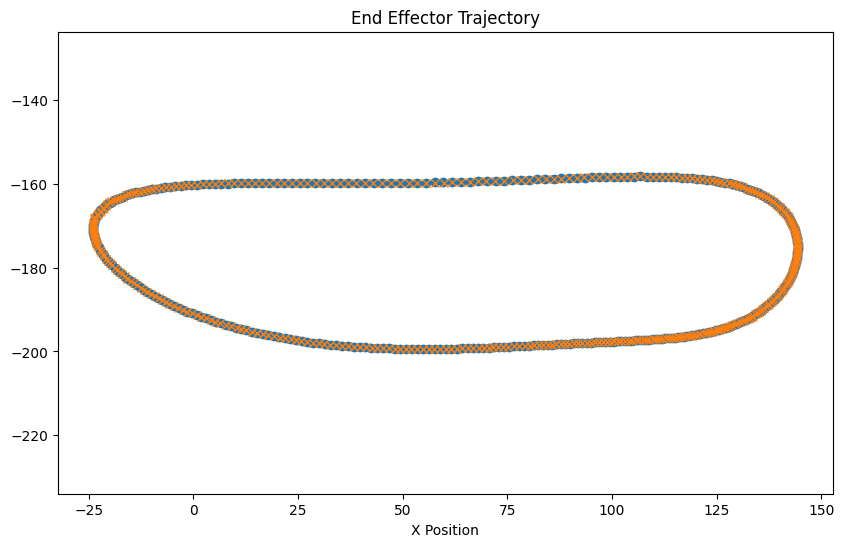

Mean End Effector Position Error: 0.0611


In [40]:
# 输入所有的x
device = next(model.parameters()).device  # 获取模型所在设备
x_tensor = torch.tensor(x_norm, dtype=torch.float32).to(device)
y_pred_norm = model(x_tensor).detach().cpu().numpy()
y_pred = y_pred_norm * (y_max - y_min) + y_min

def compute_end_effector_position(y_pred):
    r0 = 84
    r3 = 60
    r6 = 50.53
    r8 = 53.7
    r9 = 140
    theta0 = 35*np.pi/180
    theta3_6 = 15*np.pi/180
    theta8_9 = 30*np.pi/180
    theta3_true = theta0 + y_pred[:,0]
    theta6_true = theta3_true + theta3_6
    theta8_true = theta6_true + y_pred[:,4]
    theta9_true = theta8_true + theta8_9
    x_9_true = r0 * np.cos(theta0) + r3 * np.cos(theta3_true) + r6 * np.cos(theta6_true) + r9 * np.cos(theta9_true)
    y_9_true = r0 * np.sin(theta0) + r3 * np.sin(theta3_true) + r6 * np.sin(theta6_true) + r9 * np.sin(theta9_true)
    return x_9_true, y_9_true

x_9_pre, y_9_pre = compute_end_effector_position(y_pred)
x_9_true, y_9_true = compute_end_effector_position(y_true)
plt.figure(figsize=(10,6))
plt.plot(x_9_true, y_9_true, 'o')
plt.plot(x_9_pre, y_9_pre, 'x')
plt.title("End Effector Trajectory")
plt.xlabel("X Position")
plt.axis('equal')
plt.show()

error= np.mean(np.sqrt((x_9_pre - x_9_true)**2 + (y_9_pre - y_9_true)**2))
print(f"Mean End Effector Position Error: {error:.4f}")

In [41]:
x_train.shape[1], y_train.shape[1]

(1, 8)